<a href="https://colab.research.google.com/github/mr-alamdari/Binary-Classification-Pytorch/blob/main/Binary_Classification_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw
import torch
import torchvision
import torchsummary

#1.Data

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle competitions download -c histopathologic-cancer-detection
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

0    59.496875
1    40.503125
Name: label, dtype: float64


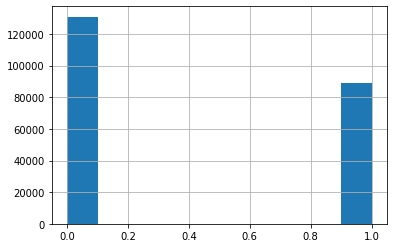

In [4]:
path2csv = './train_labels.csv'
labels_df = pd.read_csv(path2csv)
print(100*labels_df['label'].value_counts()/len(labels_df))
labels_df['label'].hist()

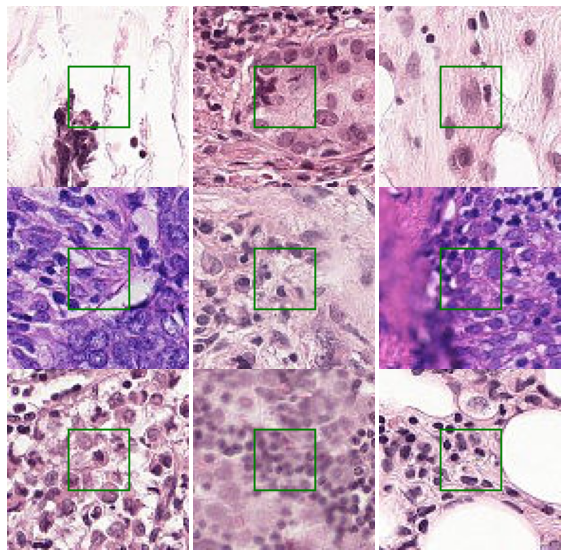

In [9]:
malignantIds = labels_df.loc[labels_df['label'] == 1]['id'].values
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows, ncols = 3, 3
color=True
for i , id in enumerate(malignantIds[:nrows*ncols]):
  full_path = os.path.join('/content/train', id+'.tif')
  img = Image.open(full_path)
  draw = ImageDraw.Draw(img)
  draw.rectangle(((32, 32), (64, 64)), outline='green')
  plt.subplot(nrows, ncols, i+1)
  if color:
    plt.imshow(np.array(img))
  else:
    plt.imshow(np.array(img)[:,:,0], cmap='gray')
  plt.axis('off')

In [10]:
torch.manual_seed(32)

class HistoCancerDataset(torch.utils.data.Dataset):
  def __init__(self, data_dir, transform, data_type='train'):
    self.data_type = data_type
    path2data = os.path.join(data_dir, self.data_type)
    filenames = os.listdir(path2data)
    self.full_filenames = [os.path.join(path2data, f) for f in filenames]

    if self.data_type == 'train':
      path2csvLabels = os.path.join(data_dir, f'{self.data_type}_labels.csv')
      labels_df = pd.read_csv(path2csvLabels)
      labels_df.set_index('id', inplace=True)
      self.labels = [labels_df.loc[f_name[:-4]].values[0] for f_name in filenames]
    self.transform = transform
  
  def __len__(self):
    return len(self.full_filenames)

  def __getitem__(self, idx):
    image = Image.open(self.full_filenames[idx])
    image = self.transform(image)
    if self.data_type == 'train':
      return image, self.labels[idx]
    return image

In [14]:
data_transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = HistoCancerDataset('/content', data_transformer, 'train')

In [17]:
len_train = int(0.8 * len(train_dataset))
len_val = len(train_dataset) - len_train
train_ds, val_ds = torch.utils.data.random_split(train_dataset, [len_train, len_val])

In [15]:
def show(img, y, color=True):
  npimg = img.numpy()
  npimg_tr = npimg.transpose((1, 2, 0))
  if color:
    plt.imshow(npimg_tr, interpolation='nearest')
  else:
    plt.imshow(npimg_tr[:, : 0], interpolation='nearest', cmao='gray')
  plt.title(f'Label: {y}')  
  
def show_random(ds, grid_size=4, color=True):
  rnd_inds = np.random.randint(0, len(ds), grid_size)

  x_grid_train = [ds[i][0] for i in rnd_inds]
  y_grid_train = [ds[i][1] for i in rnd_inds]

  x_grid_train = torchvision.utils.make_grid(x_grid_train, nrow=grid_size, padding=2)
  plt.rcParams['figure.figsize'] = (10.0, 5)
  show(x_grid_train, y_grid_train, color)  

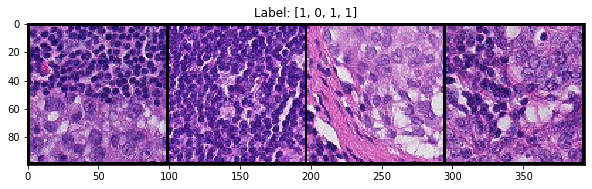

In [18]:
show_random(train_ds)

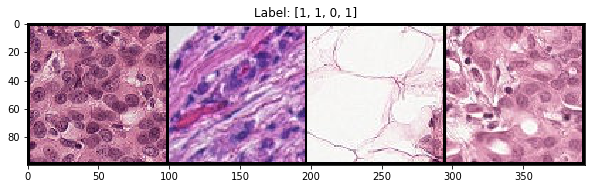

In [19]:
show_random(val_ds)